In [ ]:
import numpy as np 
import pandas as pd
import os
import PIL
import glob 
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

from torchsummary import summary

from google.colab import drive

drive = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data
train_images = r'/content/drive/MyDrive/DSBA/Hurricane_Harvey/augmented/train'
train_masks = r'/content/drive/MyDrive/DSBA/Hurricane_Harvey/augmented/mask'
test_images = r'/content/drive/MyDrive/DSBA/Hurricane_Harvey/test'

In [ ]:
train_files = os.listdir(train_images)
train_files = [x.split('.')[0] for x in train_files if x[0].isnumeric()]
train_files = np.array(train_files)
train_files = np.random.choice(train_files, size=1000, replace=False)
# Split data
X_train, X_val = train_test_split(train_files, test_size=0.2)

In [ ]:
dim = 512
#img_list = []

#for im_file in train_files:
#    img = cv2.imread(f'{train_images}/{im_file}.tif')
#    img = cv2.resize(img,(dim,dim))
#    img = img / 255.0

#    img_list.append(img)

#img_list = np.stack(img_list)
#print(img_list.shape)

#means = np.mean(img_list,axis=(0,1,2))
#stdevs = np.std(img_list,axis=(0,1,2))

#print(means,stdevs)

In [ ]:
class UAVDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, aug=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.aug = aug
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(f'{self.img_path}/{self.X[idx]}.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
        mask = cv2.imread(f'{self.mask_path}/{self.X[idx]}.png', cv2.IMREAD_GRAYSCALE)
        if self.aug is not None:
            aug = self.aug(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.aug is None:
            img = Image.fromarray(img)
        
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(self.mean, self.std)])
        img = transform(img)

        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [ ]:
means = [0.38980951, 0.46497215, 0.43926388]
stdevs = [0.21997646, 0.19580692, 0.21212297]

transform_train = A.Compose([A.Resize(dim, dim, interpolation=cv2.INTER_NEAREST)])                              

transform_val = A.Compose([A.Resize(dim, dim, interpolation=cv2.INTER_NEAREST)])

In [ ]:
#datasets
train_set = UAVDataset(train_images, train_masks, X_train, means, stdevs, transform_train)
val_set = UAVDataset(train_images, train_masks, X_val, means, stdevs, transform_val)

#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
#model = torchvision.models.resnet18(pretrained=True)
# Freeze all the layers bar the last one
#for param in model.parameters():
#    param.requires_grad = False

model.classifier = DeepLabHead(2048, 27)
# Set the model in training mode
model.train()


lr = 0.001

model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
epochs = 20

#summary(model,(3,512,512))

model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
total_train_losses = []
total_val_losses = []

for epoch in range(epochs):
      train_losses = []
      val_losses = []

      model.train()
      for i, (images, labels) in enumerate(train_loader):
          
          images = images.to(device=device, dtype=torch.float)
          labels = labels.to(device=device, dtype=torch.int64)
          
          # Clear gradients
          optimizer.zero_grad()
          
          # Forward propagation
          outputs = model(images)['out']
        
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs, labels)
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          train_losses.append(loss.item())

      train_loss_mean = np.mean(train_losses)
      total_train_losses.append(train_loss_mean)

      model.eval()
      for i, (images, labels) in enumerate(val_loader):
        
        images = images.to(device)
        labels = labels.to(device)
       
        target = model(images)['out']

        loss = criterion(target, labels)
        
        val_losses.append(loss.item())
        
      val_loss_mean = np.mean(val_losses)
      total_val_losses.append(val_loss_mean)

      print(f"Epoch {epoch} Training loss: {train_loss_mean} Validation loss: {val_loss_mean}")




Epoch 0 Training loss: 1.4810097002983094 Validation loss: 1.1202222204208374
Epoch 1 Training loss: 1.011407095193863 Validation loss: 0.90559490442276
Epoch 2 Training loss: 0.9316521084308624 Validation loss: 0.9804254722595215
Epoch 3 Training loss: 0.8505500328540802 Validation loss: 0.8044417905807495
Epoch 4 Training loss: 0.7714683943986893 Validation loss: 0.8077464675903321
Epoch 5 Training loss: 0.719879669547081 Validation loss: 0.6947702932357788
Epoch 6 Training loss: 0.7156504416465759 Validation loss: 0.6952582263946533
Epoch 7 Training loss: 0.6478254878520966 Validation loss: 0.648983805179596
Epoch 8 Training loss: 0.6520348525047303 Validation loss: 0.633646959066391
Epoch 9 Training loss: 0.6232118898630142 Validation loss: 0.8840858387947083
Epoch 10 Training loss: 0.6141450515389443 Validation loss: 0.6334387695789337
Epoch 11 Training loss: 0.6238973316550255 Validation loss: 0.6335905158519745
Epoch 12 Training loss: 0.5528225621581078 Validation loss: 0.624964

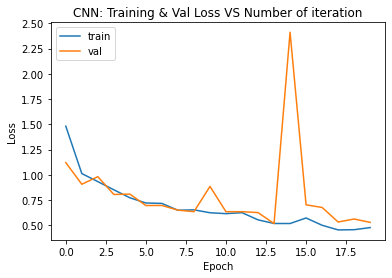

In [ ]:
plt.figure()
plt.plot(total_train_losses)
plt.plot(total_val_losses)
plt.title("CNN: Training & Val Loss VS Number of iteration")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_files = os.listdir(test_images)
test_files = [x.split('.')[0] for x in test_files if x[0].isnumeric()]
test_files.sort()
test_files = np.array(test_files)

#dim = 512
#img_list = []

#for im_file in test_files:
#    img = cv2.imread(f'{test_images}/{im_file}.tif')
#    img = cv2.resize(img,(dim,dim))
#    img = img / 255.0

#    img_list.append(img)

#img_list = np.stack(img_list)
#print(img_list.shape)

#means = np.mean(img_list,axis=(0,1,2))
#stdevs = np.std(img_list,axis=(0,1,2))

#print(means,stdevs)

In [ ]:
means = [0.3720225,  0.44640904, 0.42115532]
stdevs = [0.21046157, 0.18250105, 0.20091524]

In [ ]:
class testDataset(Dataset):
    
    def __init__(self, img_path, X, mean, std, aug=None):
        self.img_path = img_path
        self.X = X
        self.aug = aug
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(f'{self.img_path}/{self.X[idx]}.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
        if self.aug is not None:
            aug = self.aug(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.aug is None:
            img = Image.fromarray(img)
        
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(self.mean, self.std)])
        img = transform(img)
            
        return img

In [ ]:

test_set = testDataset(test_images, test_files, means, stdevs, transform_val)

#dataloader
batch_size= 1

test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 1, shuffle=False)

In [ ]:
from itertools import islice
#Predict the test set maps
model.eval()
test_predictions = []
for image in test_loader:
    with torch.no_grad():
        image = image.to(device)
        prediction = model(image)['out']
        test_predictions.append(np.uint8(prediction.argmax(1).cpu().numpy()[0]))


In [ ]:
#Saving images to output path 
test_dir = r'/content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/'
test_img_names = list(test_files)
d = dict(zip(test_img_names,test_predictions))
for name, pred in d.items():
    im = Image.fromarray(pred)
    im.save(test_dir+name+'.png')
    print("Image saved: ", test_dir + name + '.png')

Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/10184.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/10300.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6414.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6427.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6447.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6456.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6469.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6499.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6548.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6569.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6574.png
Image saved:  /content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred/6580.png
Im

In [ ]:
# Dictionary to store the image sizes

images = os.listdir(test_images)
images = [x for x in images if x[0].isnumeric()]

def get_size(images):
  image_size = {}
  for image in images:
    image_id = image.split('.')[0]
    
    with PIL.Image.open(f'{test_images}/{image}') as im:
      width, height = im.size
      image_size[image_id] = (width, height)

  return image_size

image_size = get_size(images)

In [ ]:
image_paths = r'/content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred'
reshape_dir = r'/content/drive/MyDrive/DSBA/Hurricane_Harvey/deeplabv3/pred_resize'

images = os.listdir(image_paths)
images = [x for x in images if x[0].isnumeric()]

# the target size is image_size
for file_path in images:
  image_id = file_path.split('.')[0]
  width,height = image_size[image_id]

  im = cv2.imread(f'{image_paths}/{file_path}', cv2.IMREAD_GRAYSCALE)
  im = cv2.resize(im,(width, height),interpolation = cv2.INTER_NEAREST)
  cv2.imwrite(f'{reshape_dir}/{file_path}',im)

In [ ]:
# zip file
import tarfile  

tar = tarfile.open("submission.zip", "w")  
for root, dir, files in os.walk(reshape_dir):
  for file in files:
    fullpath = os.path.join(root, file)
    tar.add(fullpath, arcname=file)
tar.close()

In [ ]:
# check if reshape is successful

f = os.listdir(reshape_dir)

image_size = {}
for image in f:
  image_id = image.split('.')[0]
  with PIL.Image.open(f'{reshape_dir}/{image}') as im:
    width, height = im.size
    image_size[image_id] = (width, height)
print(image_size)

{'10184': (4000, 3000), '10300': (4000, 3000), '6414': (4000, 3000), '6427': (4000, 3000), '6447': (4000, 3000), '6456': (4000, 3000), '6469': (4000, 3000), '6499': (4000, 3000), '6548': (4000, 3000), '6569': (4000, 3000), '6574': (4592, 3072), '6580': (4592, 3072), '6603': (4592, 3072), '6608': (4592, 3072), '6639': (4000, 3000), '6645': (4000, 3000), '6649': (4000, 3000), '6659': (4000, 3000), '6691': (4592, 3072), '6703': (4000, 3000), '6710': (4592, 3072), '6715': (4592, 3072), '6794': (4000, 3000), '6796': (4000, 3000), '6820': (4000, 3000), '6829': (4000, 3000), '6933': (4000, 3000), '6939': (4000, 3000), '6946': (4000, 3000), '6979': (4000, 3000), '7241': (4592, 3072), '7245': (4592, 3072), '7252': (4592, 3072), '7258': (4592, 3072), '7298': (4000, 3000), '7301': (4592, 3072), '7305': (4592, 3072), '7306': (4592, 3072), '7310': (4592, 3072), '7315': (4592, 3072), '7318': (4592, 3072), '7320': (4592, 3072), '7336': (4592, 3072), '7415': (4592, 3072), '7429': (4592, 3072), '7473':